# Objective and Motivation

## Objective

## Overview of Wind Turbine Anatomy

## Wind Turbine Aerodynamics

# Code

## Prepare Data

### Pip Install, Init, and Start Pyspark

In [435]:
# from pyspark.sql import SparkSession
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# from pyspark.sql import functions as F
# from pyspark.sql import types as T
# from pyspark.sql.functions import broadcast
# from pyspark.sql.functions import col
# from pyspark.sql.functions import *
import seaborn as sns

%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

In [436]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, f1_score, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
import sklearn
from sklearn.model_selection import train_test_split

In [437]:
import mlflow
import optuna

In [438]:
Path.cwd().joinpath("mlruns").as_uri()

'file:///home/mathewlee/Developer/wind-energy-forecasting/experiments/mlruns'

In [439]:
# from ydata_profiling import ProfileReport

In [440]:
# spark = SparkSession.builder.master("local[*]").getOrCreate()
# sc = spark.sparkContext

In [441]:
# Get the number of cores
# num_cores = sc.defaultParallelism

# Get the number of executors
# num_executors = sc.getConf().get("spark.executor.instances")

# print(num_cores)
# print(num_executors)

### Import Data 

In [442]:
print(os.getcwd())

/home/mathewlee/Developer/wind-energy-forecasting/experiments


In [443]:
df = pd.read_csv("../src/main/resources/data/Turbine_Data.csv")

In [444]:
# df = (spark.read
#       .option("header", "true")
#       .option("inferSchema", "true")
#       .csv("../data/Turbine_Data.csv"))

In [445]:
# df.printSchema()

### Transform Data

In [446]:
# df_renamed = df.withColumnRenamed("_c0", "datetime_stamp")


In [447]:
df_renamed = df.rename({"Unnamed: 0": "datetime_stamp"}, axis=1)

In [448]:
df_renamed.columns

Index(['datetime_stamp', 'ActivePower', 'AmbientTemperatue',
       'BearingShaftTemperature', 'Blade1PitchAngle', 'Blade2PitchAngle',
       'Blade3PitchAngle', 'ControlBoxTemperature',
       'GearboxBearingTemperature', 'GearboxOilTemperature', 'GeneratorRPM',
       'GeneratorWinding1Temperature', 'GeneratorWinding2Temperature',
       'HubTemperature', 'MainBoxTemperature', 'NacellePosition',
       'ReactivePower', 'RotorRPM', 'TurbineStatus', 'WTG', 'WindDirection',
       'WindSpeed'],
      dtype='object')

In [449]:
df_renamed['datetime_stamp'] = pd.to_datetime(df_renamed['datetime_stamp'])

In [450]:
df_indexed_sorted = df_renamed.set_index("datetime_stamp").sort_index()

In [451]:
df_indexed_sorted.dtypes

ActivePower                     float64
AmbientTemperatue               float64
BearingShaftTemperature         float64
Blade1PitchAngle                float64
Blade2PitchAngle                float64
Blade3PitchAngle                float64
ControlBoxTemperature           float64
GearboxBearingTemperature       float64
GearboxOilTemperature           float64
GeneratorRPM                    float64
GeneratorWinding1Temperature    float64
GeneratorWinding2Temperature    float64
HubTemperature                  float64
MainBoxTemperature              float64
NacellePosition                 float64
ReactivePower                   float64
RotorRPM                        float64
TurbineStatus                   float64
WTG                              object
WindDirection                   float64
WindSpeed                       float64
dtype: object

In [452]:
pdf = df_indexed_sorted.copy()

In [453]:
# df_casted = df_renamed.withColumn("datetime_stamp", col("datetime_stamp").cast("timestamp")).drop(col("_c0"))
# df_casted.printSchema()

In [454]:
# df_filtered = df_casted.where(
#     to_date(col("datetime_stamp")) =="2018-01-01"
#     )

In [455]:
# pdf = df_casted.toPandas()

In [456]:
# profile = ProfileReport(pdf, title="YData Profiling Report")
# profile.to_file('profiling_report.html');

### Drop Empty or Single Value Cols

In [457]:
pdf_drop_bad_cols = pdf.drop(columns=['ControlBoxTemperature', 'TurbineStatus', 'WTG'], axis=1)

In [458]:
type(pdf_drop_bad_cols)

pandas.core.frame.DataFrame

### Drop Highly Correlated Columns

In [459]:
corr_matrix = pdf_drop_bad_cols.corr()
corr_matrix


,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,WindDirection,WindSpeed
ActivePower,1.000000,-0.065637,0.655400,-0.368997,-0.367978,-0.367978,0.818850,0.821921,0.849604,0.931390,0.932521,0.347363,0.101627,0.028108,0.719092,0.849069,0.028108,0.940390
AmbientTemperatue,-0.065637,1.000000,0.246505,0.085461,0.090904,0.090904,0.017216,0.162511,-0.130123,0.077859,0.078736,0.589729,0.836539,-0.037498,-0.020313,-0.129290,-0.037498,-0.095308
BearingShaftTemperature,0.655400,0.246505,1.000000,-0.475557,-0.466856,-0.466856,0.883344,0.772887,0.640947,0.765115,0.763926,0.809116,0.542104,0.183929,0.594546,0.640584,0.183929,0.596201
Blade1PitchAngle,-0.368997,0.085461,-0.475557,1.000000,0.997774,0.997774,-0.599178,-0.557949,-0.757056,-0.376102,-0.372369,-0.198583,0.194911,-0.058300,-0.381478,-0.757147,-0.058300,-0.403092
Blade2PitchAngle,-0.367978,0.090904,-0.466856,0.997774,1.000000,1.000000,-0.592103,-0.549792,-0.754325,-0.371057,-0.367451,-0.190296,0.190562,-0.057624,-0.379541,-0.754539,-0.057624,-0.402786
Blade3PitchAngle,-0.367978,0.090904,-0.466856,0.997774,1.000000,1.000000,-0.592103,-0.549792,-0.754325,-0.371057,-0.367451,-0.190296,0.190562,-0.057624,-0.379541,-0.754539,-0.057624,-0.402786
GearboxBearingTemperature,0.818850,0.017216,0.883344,-0.599178,-0.592103,-0.592103,1.000000,0.906020,0.850209,0.853024,0.851923,0.596065,0.307694,0.214486,0.751875,0.850795,0.214486,0.800433
GearboxOilTemperature,0.821921,0.162511,0.772887,-0.557949,-0.549792,-0.549792,0.906020,1.000000,0.806972,0.899693,0.898335,0.506648,0.190350,0.277619,0.770088,0.807776,0.277619,0.793140
GeneratorRPM,0.849604,-0.130123,0.640947,-0.757056,-0.754325,-0.754325,0.850209,0.806972,1.000000,0.796434,0.795223,0.303804,-0.052185,0.176964,0.768065,0.999723,0.176964,0.854787
GeneratorWinding1Temperature,0.931390,0.077859,0.765115,-0.376102,-0.371057,-0.371057,0.853024,0.899693,0.796434,1.000000,0.999959,0.481905,0.215955,0.298452,0.838461,0.797077,0.298452,0.894777


In [460]:
corr_matrix.abs().unstack()["NacellePosition"]

ActivePower                     0.028108
AmbientTemperatue               0.037498
BearingShaftTemperature         0.183929
Blade1PitchAngle                0.058300
Blade2PitchAngle                0.057624
Blade3PitchAngle                0.057624
GearboxBearingTemperature       0.214486
GearboxOilTemperature           0.277619
GeneratorRPM                    0.176964
GeneratorWinding1Temperature    0.298452
GeneratorWinding2Temperature    0.298708
HubTemperature                  0.128150
MainBoxTemperature              0.005701
NacellePosition                 1.000000
ReactivePower                   0.294038
RotorRPM                        0.176511
WindDirection                   1.000000
WindSpeed                       0.034355
dtype: float64

In [461]:
corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().head(20)

WindSpeed                     WindSpeed                       1.000000
GeneratorWinding2Temperature  GeneratorWinding1Temperature    0.999959
GeneratorRPM                  RotorRPM                        0.999723
Blade3PitchAngle              Blade1PitchAngle                0.997774
WindSpeed                     ActivePower                     0.940390
ActivePower                   GeneratorWinding2Temperature    0.932521
                              GeneratorWinding1Temperature    0.931390
GearboxBearingTemperature     GearboxOilTemperature           0.906020
GearboxOilTemperature         GeneratorWinding1Temperature    0.899693
                              GeneratorWinding2Temperature    0.898335
WindSpeed                     GeneratorWinding2Temperature    0.894834
                              GeneratorWinding1Temperature    0.894777
GearboxBearingTemperature     BearingShaftTemperature         0.883344
RotorRPM                      WindSpeed                       0.855584
Genera

In [462]:
### Drop highly correlated features
### pdf[["WindSpeed","ActivePower"]]
### pdf[["RotorRPM", "GeneratorRPM"]]
### pdf[["AmbientTemperatue", "MainBoxTemperature"]]
### pdf[["Blade1PitchAngle","Blade2PitchAngle", "Blade3PitchAngle"]]
### pdf[["NacellePosition","WindDirection"]]


df_drop_corr_cols = pdf.drop(["NacellePosition","RotorRPM", "AmbientTemperatue", "Blade2PitchAngle", "Blade3PitchAngle"], axis=1)


In [463]:
df_drop_corr_cols

,ActivePower,BearingShaftTemperature,Blade1PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,ReactivePower,TurbineStatus,WTG,WindDirection,WindSpeed
datetime_stamp,,,,,,,,,,,,,,,,
2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-30 23:10:00+00:00,70.044465,45.711129,1.515669,0.0,59.821165,55.193793,1029.870744,59.060367,58.148777,39.008931,36.476562,13.775785,2.0,G01,178.0,3.533445
2020-03-30 23:20:00+00:00,40.833474,45.598573,1.702809,0.0,59.142038,54.798545,1030.160478,58.452003,57.550367,39.006759,36.328125,8.088928,2.0,G01,178.0,3.261231
2020-03-30 23:30:00+00:00,20.777790,45.462045,1.706214,0.0,58.439439,54.380456,1030.137822,58.034071,57.099335,39.003815,36.131944,4.355978,2.0,G01,178.0,3.331839


### Drop Null Rows

In [464]:
df_drop_nulls = df_drop_corr_cols.dropna(subset=["ActivePower"]).sort_index()
# df_drop_nulls = df_drop_corr_cols.sort_index()

In [465]:
### Percent non-null
df_drop_nulls.shape[0]/pdf.shape[0]

0.8014447151170659

In [466]:
df_drop_nulls.shape

(94750, 16)

### Train/Test Split

In [467]:
def train_test_split_by_date(df: pd.DataFrame, train_test_date_split_mid_pt: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    X_train = df.iloc[df.index <= train_test_date_split_mid_pt]
    X_test = df.iloc[df.index > train_test_date_split_mid_pt]
    # print(X_train)
    # print(X_test)
    return X_train, X_test

train_test_date_split_mid_pt = "2019-03-01"

X_train_time_series, X_test_time_series = train_test_split_by_date(df_drop_nulls, train_test_date_split_mid_pt)

In [468]:
### Plot x_train and x_test
y_var = "ActivePower"

plt.figure(figsize=(10, 6))
plt.plot(X_train_time_series[y_var])
plt.plot(X_test_time_series[y_var])
plt.title("Active Power Generated")
plt.xlabel("Date")
plt.ylabel("ActivePower")
time_series_fn = f"./figures/time_series.png"
plt.savefig(time_series_fn)
plt.close()
# plt.show()

In [469]:
def resample_mean(X_train: pd.DataFrame, X_test: pd.DataFrame, y_variable: str, grain: str) -> tuple[pd.Series, pd.Series]:
    return X_train[y_variable].resample(grain).mean(), X_test[y_variable].resample(grain).mean()

X_train_resampled, X_test_resampled = resample_mean(X_train_time_series, X_test_time_series, y_variable=y_var, grain="W-MON")

In [475]:
### Plot x_train and x_test
plt.figure(figsize=(10, 6))
plt.plot(X_train_resampled)
plt.plot(X_test_resampled)
plt.title("Active Power Generated")
plt.xlabel("Date")
plt.ylabel("ActivePower")
time_series_resampled_fn = f"./figures/time_series_resampled.png"
plt.savefig(time_series_resampled_fn)
plt.close()
# plt.show()

In [472]:
# def _apply_differencing(self, time_series: pd.Series):
    # return diff(time_series, k_seasonal_diff=1, seasonal_periods=self.seasonal_periods)


## Fit and Forecast (SARIMA)

In [473]:
import mlflow
import mlflow.data

mlflow.set_experiment("wind-energy-forecasting")

# Enable autologging for scikit-learn
mlflow.statsmodels.autolog()

### Evaluation Functions

In [ ]:
def check_stationarity(self, time_series: pd.Series) -> None:
    result = adfuller(time_series, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
    return None

In [ ]:
def evaluate_forecast(X_test: pd.Series, forecast) -> tuple[float, float, float, float]:
    # print(X_test[1:].sort_index())
    # print(forecast.sort_index())

    mae = mean_absolute_error(X_test[1:], forecast)
    mape = mean_absolute_percentage_error(X_test[1:], forecast)
    mse = mean_squared_error(X_test[1:], forecast)
    rmse = root_mean_squared_error(X_test[1:], forecast)

    print(f'MAE: {mae}')
    print(f'MAE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')

    return mae, mape, mse, rmse

### Optuna

In [498]:
def objective(trial):
    # Setting nested=True will create a child run under the parent run.
    with mlflow.start_run(nested=True, run_name=f"trial_{trial.number}") as child_run:
        max_p = trial.suggest_int("max_p", 1, 3)
        max_d = trial.suggest_int("max_d", 1, 3)
        max_q = trial.suggest_int("max_q", 1, 3)
        max_P = trial.suggest_int("max_P", 1, 3)
        max_D = trial.suggest_int("max_D", 1, 3)
        max_Q = trial.suggest_int("max_Q", 1, 3)
        max_seasonal_periods = trial.suggest_int("max_seasonal_periods", 4, 52)
        forecast_n_steps = len(X_test_resampled) - 1

        print("FORECAST", forecast_n_steps)

        X_train_dataset = mlflow.data.from_pandas(X_train_time_series)
        X_test_dataset = mlflow.data.from_pandas(X_test_time_series)
        X_train_resampled_dataset = mlflow.data.from_pandas(pd.DataFrame(X_train_resampled))
        X_test_resampled_dataset = mlflow.data.from_pandas(pd.DataFrame(X_test_time_series))

        params = {
            "max_p": max_p,
            "max_d": max_d,
            "max_q": max_q,
            "max_P": max_P,
            "max_D": max_D,
            "max_Q": max_Q,
            "max_seasonal_periods": max_seasonal_periods,
            "random_state": 42,
            
        }

        # Log current trial's parameters
        mlflow.log_params(params)

        # Optional: Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", "Time Series forecasting via SARIMA")

        mlflow.log_inputs(
            datasets=[X_train_dataset, X_test_dataset, X_train_resampled_dataset, X_test_resampled_dataset],
        contexts=["Training", "Testing", "Training Resampled", "Testing Resampled"],
                tags_list=[None, {"my_tag": "tag_value"}, None, None],
        )


        ### Log ACF
        plot_acf(X_train_resampled)
        acf_fn = f"./figures/acf_{trial.number}.png"
        plt.savefig(acf_fn)
        mlflow.log_artifact(acf_fn) # logging to mlflow      
        plt.close()
        # plt.show()
        
        
        ### Log PACF
        plot_pacf(X_train_resampled)
        pacf_fn = f"./figures/pacf_{trial.number}.png"
        plt.savefig(pacf_fn)
        mlflow.log_artifact(pacf_fn) # logging to mlflow      
        plt.close()
        # plt.show()

                
        ## Fit and forecast
        model = SARIMAX(X_train_resampled, order=(max_p, max_d, max_q), seasonal_order=(max_P, max_D, max_Q, max_seasonal_periods))
        fit_model = model.fit()
        forecast = fit_model.get_forecast(steps=forecast_n_steps)
        forecast_values = forecast.predicted_mean
        forecast_ci = forecast.conf_int()
        

        ### Plot Training, Testing, Forecast, and CI
        plt.figure(figsize=(10, 6))
        plt.plot(X_train_resampled, label='Training')
        plt.plot(X_test_resampled, label='Actuals', color='orange')
        plt.plot(forecast_values, label='Forecast', color='red')
        plt.fill_between(forecast_ci.index,
                        forecast_ci.iloc[:,0],
                        forecast_ci.iloc[:,1],
                        color='k', alpha=.15)
        plt.title("Active Power Forecast")
        plt.xlabel("Date")
        plt.ylabel("Sales")
        plt.legend()
        train_test_fcst_ci_fn = f"./train_test_fcst_ci_{trial.number}.png"
        plt.savefig(train_test_fcst_ci_fn)
        mlflow.log_artifact(train_test_fcst_ci_fn) # logging to mlflow      
        plt.close
        # plt.show()

        ## Log plot_diagnostics()
        forecast.plot_diagnostics()
        diagnostics_fn = f"./figures/diagnostics_{trial.number}.png"
        plt.savefig(diagnostics_fn)
        mlflow.log_artifact(diagnostics_fn) # logging to mlflow      
        plt.close()
        # plt.show()


        # Log Input
        # mlflow.log_input(pd.DataFrame(weekly_forecast.X_train_resampled), context="Training Data Resampled")
        # mlflow.log_input(pd.DataFrame(weekly_forecast.X_test_resampled), context="Test Data Resampled")
        
        # Log the hyperparameters
        # mlflow.log_params(params)

        # Log the model
        # model_info = mlflow.sklearn.log_model(sk_model=lr, name="iris_model")
        
        # Predict on the test set, compute and log the loss metric
        mae, mape, mse, rmse = evaluate_forecast(X_test_resampled, forecast_values)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mape", mape)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        # mlflow.log_metric("residuals", residuals)
        mlflow.log_metrics({"mae": mae, "mape": mape, "mse": mse, "rmse": rmse})


        # Log the model file
        # mlflow.statsmodels.log_model(fit_model, name="model", remove_data=True)

        # Make it easy to retrieve the best-performing child run later
        trial.set_user_attr("run_id", child_run.info.run_id)
        return fit_model.aic
    


[I 2025-12-14 21:01:56,754] A new study created in memory with name: no-name-cb80b891-3f2e-41d8-aa3b-c97f7f07e7f9


FORECAST 56


/home/mathewlee/Developer/wind-energy-forecasting/.venv/lib64/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/mathewlee/Developer/wind-energy-forecasting/.venv/lib64/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
2025/12/14 21:01:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/14 21:01:58 WARNING mlflow.statsmodels: The fitted model is larger than 100 MB, saving it as artifacts is time consuming.
To reduce model size, use `mlflow.statsmodels.autolog(log_models=False)` and manually 

AttributeError: 'PredictionResults' object has no attribute 'plot_diagnostics'

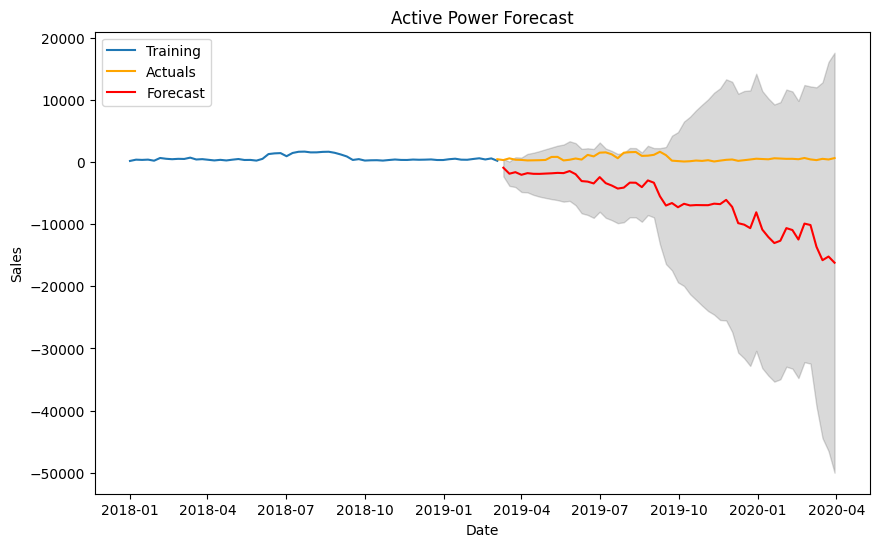

In [499]:
# Start an MLflow run)
with mlflow.start_run(run_name='SARIMAX') as run:
    n_trials = 30
    mlflow.log_param("n_trials", n_trials)

    study = optuna.create_study(direction="minimize")
    # study.optimize(objective, callbacks=[optuna.study.MaxTrialsCallback(n_trials, states=(optuna.trial.TrialState.COMPLETE,))])
    study.optimize(objective, n_trials=n_trials)

    # Log the best trial and its run ID
    mlflow.log_params(study.best_trial.params)
    mlflow.log_metrics({"best_error": study.best_value})
    if best_run_id := study.best_trial.user_attrs.get("run_id"):
        mlflow.log_param("best_child_run_id", best_run_id)



## Sources

https://www.geeksforgeeks.org/machine-learning/sarima-seasonal-autoregressive-integrated-moving-average/

In [ ]:
### Apply Differencecing
# print("Apply Differencing")
# X_train_resampled_differenced = pd.Series(self._apply_differencing(X_train_resampled))
# X_test_resampled_differenced = pd.Series(self._apply_differencing(X_test_resampled))

### Plot X_train with differencing and resampling
# print("Plotting X_train with Differencing and resampling")
# weekly_forecast._plot_time_series(X_train_resampled, X_test_resampled)
# weekly_forecast._check_stationarity(X_train_resampled)
